# Plot Simulation Results

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-pz88_9dx because the default path (/tf/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [13]:
QUERY = 'luis_lego'
yields = pd.read_hdf(f'/tf/primo/data/simulation/extended_targets/{QUERY}.h5')
#dists = pd.read_hdf('/tf/primo/data/extended_targets/query_target_dists.h5')
dists = pd.read_hdf('/tf/primo/data/targets/query_target_dists.h5')

In [24]:
df = yields.join(dists[QUERY].rename('euclidean_distance'))

In [15]:
# Yield predictor here is a differentiable DNA hybridization yield predictor (originally learned from the Nupack simulator). Represented in brown to the right of the one-hot box.
![big](../../documentation/similarity_search_schematic.jpg)df[df['euclidean_distance'] < 75]

/bin/sh: 1: Syntax error: word unexpected (expecting ")")


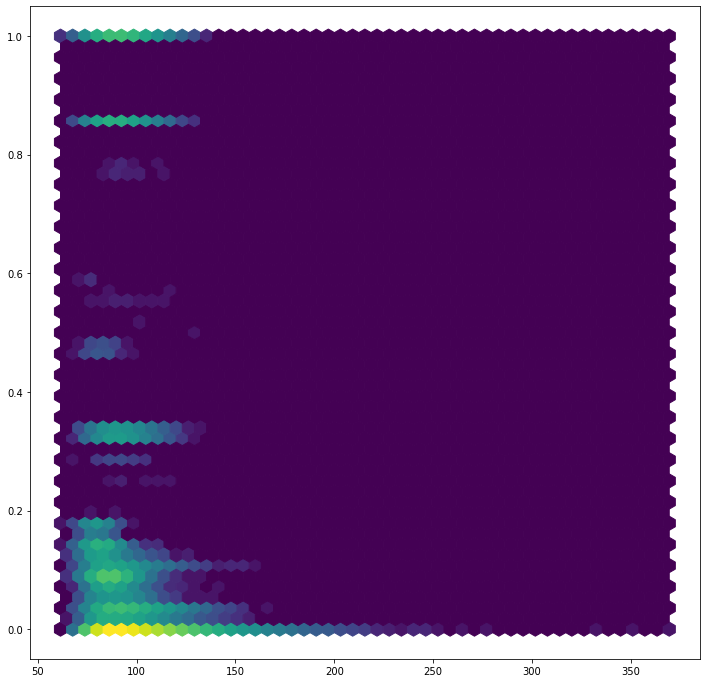

In [25]:
  [0.25,   0.25,   0.25,   0.25,  ],# Color here represents density.
# For more info on Hexbins, check out https://holypython.com/python-visualization-tutorial/creating-hexbin-charts/
plt.figure(figsize=(12,12))
plt.hexbin(df.euclidean_distance, df.duplex_yield, gridsize=50, bins='log')

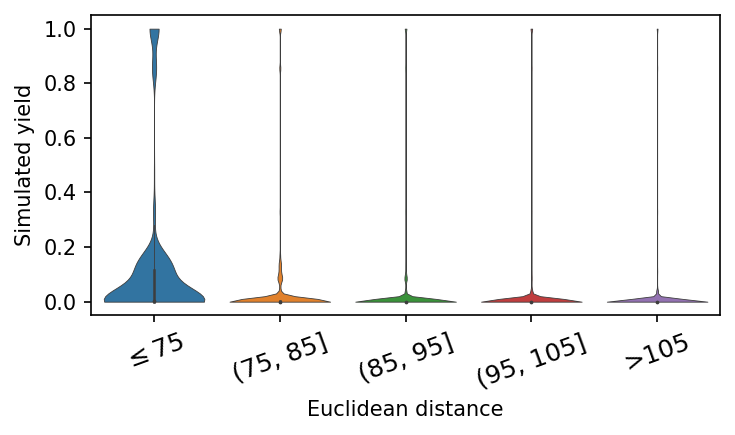

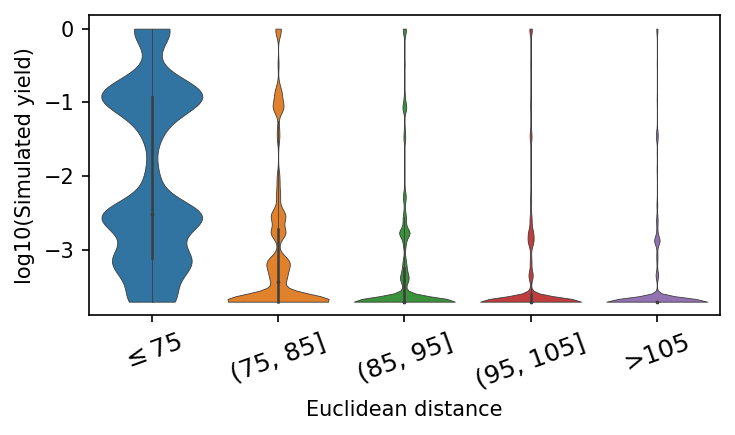

In [26]:
thresholds = [75, 85, 95, 105]
bin_labels = np.array(
    ["$\leq%d$" % thresholds[0]]
    + ["(%d, %d]" % (a,b) for (a,b) in zip(thresholds,thresholds[1:])]
    + [">%d" % thresholds[-1]]
)

df['log_yield'] = np.log10(df.duplex_yield)

plt.figure(figsize = (5, 3), dpi=150)
(lambda data:
    sns.violinplot(

        x='dist_bin',
        y='duplex_yield',
        data=data,
        linewidth=0.4,
        fliersize=0.5,
        cut=0.0,
        scale='width',
        order = bin_labels
    )
)(
    df
    .assign(
        dist_bin = lambda df: bin_labels[np.digitize(df.euclidean_distance, thresholds, right=True)]
    )
)
plt.xlabel("Euclidean distance")
plt.xticks(rotation=20)
[label.set_fontsize(12) for label in plt.gca().get_xticklabels()]
plt.ylabel("Simulated yield")
plt.tight_layout()

plt.figure(figsize = (5, 3), dpi=150)
(lambda data:
    sns.violinplot(

        x='dist_bin',
        y='log_yield',
        data=data,
        linewidth=0.4,
        fliersize=0.5,
        cut=0.0,
        scale='width',
        order = bin_labels
    )
     
)(
    df
    .assign(
        dist_bin = lambda df: bin_labels[np.digitize(df.euclidean_distance, thresholds, right=True)]
    )
)
plt.xlabel("Euclidean distance")
plt.xticks(rotation=20)
[label.set_fontsize(12) for label in plt.gca().get_xticklabels()]
plt.ylabel("log10(Simulated yield)")
plt.tight_layout()

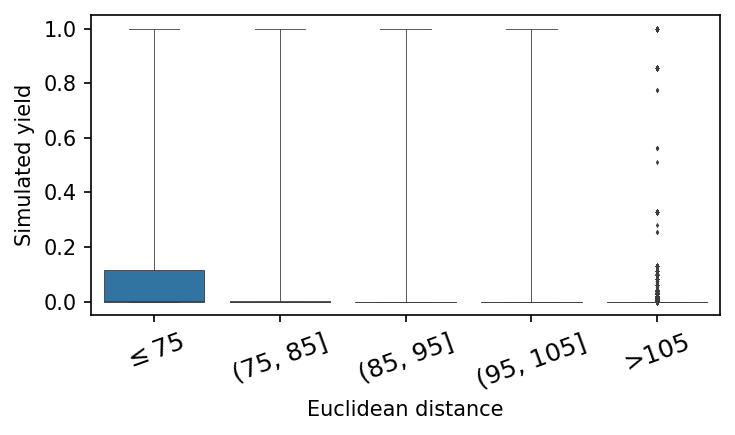

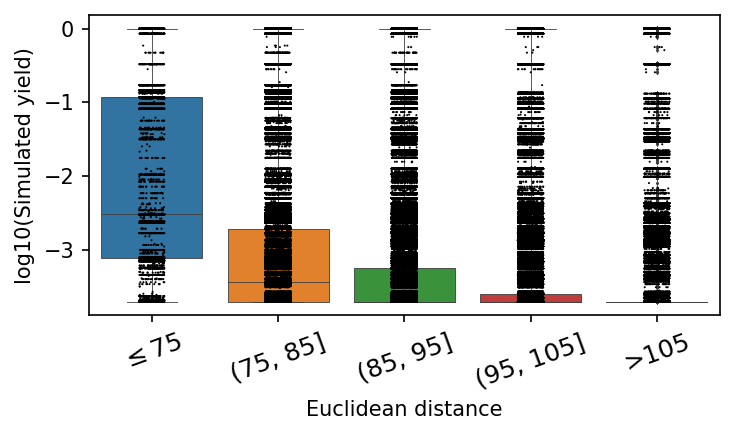

In [27]:
thresholds = [75, 85, 95, 105]
bin_labels = np.array(
    ["$\leq%d$" % thresholds[0]]
    + ["(%d, %d]" % (a,b) for (a,b) in zip(thresholds,thresholds[1:])]
    + [">%d" % thresholds[-1]]
)

df['log_yield'] = np.log10(df.duplex_yield)

plt.figure(figsize = (5, 3), dpi=150)
(lambda data:
    sns.boxplot(

        x='dist_bin',
        y='duplex_yield',
        data=data,
        linewidth=0.4,
        fliersize=0.5,
        whis=1e100,
        order = bin_labels
    )
)(
    df
    .assign(
        dist_bin = lambda df: bin_labels[np.digitize(df.euclidean_distance, thresholds, right=True)]
    )
)
plt.xlabel("Euclidean distance")
plt.xticks(rotation=20)
[label.set_fontsize(12) for label in plt.gca().get_xticklabels()]
plt.ylabel("Simulated yield")
plt.tight_layout()

plt.figure(figsize = (5, 3), dpi=150)
def plot(data):
    sns.boxplot(
        x='dist_bin',
        y='log_yield',
        data=data,
        linewidth=0.4,
        fliersize=0.5,
        whis=1e100,
        order = bin_labels
    )
    sns.stripplot(
        x='dist_bin',
        y='log_yield',
        data=data,
        size=1.0,
        color='black',
        order = bin_labels,
     )
(lambda data:
    plot(data)
)(
    df
    .assign(
        dist_bin = lambda df: bin_labels[np.digitize(df.euclidean_distance, thresholds, right=True)]
    )
)
plt.xlabel("Euclidean distance")
plt.xticks(rotation=20)
[label.set_fontsize(12) for label in plt.gca().get_xticklabels()]
plt.ylabel("log10(Simulated yield)")
plt.tight_layout()

In [28]:
def nn_recall(scores, distances, k=10, n_thresholds=500, thresholds=None):
    # Nearest-neighbor recall.
    if thresholds is None:
        thresholds = np.linspace(scores.min(), scores.max(), n_thresholds)
        thresholds[0] = (thresholds[0] + thresholds[1])/2
        
    retrieved = scores >= thresholds.reshape(-1,1)
    p_retrieved = retrieved.mean(1)
    
    neighbors = distances.argsort()[:k]
    
    nn_recall = retrieved[:, neighbors].mean(1)
    
    # Total positives / total retrieved 
    precision = retrieved[:, neighbors].sum(1) / retrieved.sum(1)
    
    return nn_recall, p_retrieved, thresholds, precision

def nn_recall_discrete(scores, distances, k=100, n_thresholds=500):
    thresholds = np.unique(np.logspace(0, np.log10(scores.max()), n_thresholds).astype(int))
    
    retrieved = scores >= thresholds.reshape(-1,1)
    p_retrieved = retrieved.mean(1)
    
    neighbors = distances.argsort()[:k]
    
    nn_recall = retrieved[:, neighbors].mean(1)
    
    return nn_recall, p_retrieved, thresholds

def plot_baselines(nn_k, n_targets, plt_fn = lambda ax: ax.loglog):
    def plot(ax):
        ax_plot = plt_fn(ax)
        unif = np.linspace(0,1,100)
        ax_plot(unif, unif, alpha=0.2, ls='--', color='black', label='Chance')
        ax_plot(unif, unif * nn_k/n_targets, alpha=0.2, ls='-.', color='black', label='Oracle')
    return plot

In [29]:
scores = 1 - df.log_yield.values / df.log_yield.min()
n,p,t, precision = nn_recall(
    df.log_yield.values,
    df.euclidean_distance.values,
    k=100,
    thresholds=np.linspace(-3.7, 0.0, 300)
)

Text(0.5, 0, 'threshold (log10 cleave rate)')

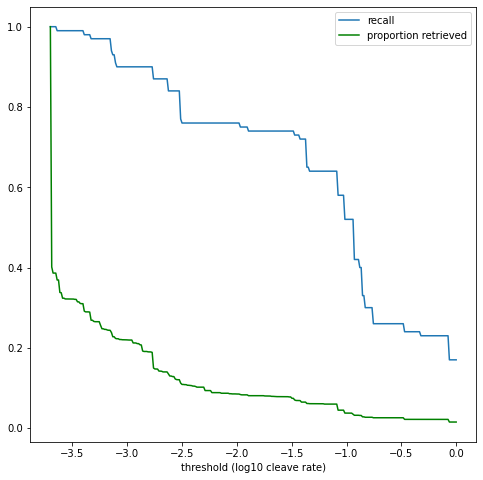

In [31]:
recall = n
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.plot(t, recall, label='recall')
ax1.plot(t, p, 'g', label='proportion retrieved')
ax1.legend()
plt.xlabel('threshold (log10 cleave rate)')

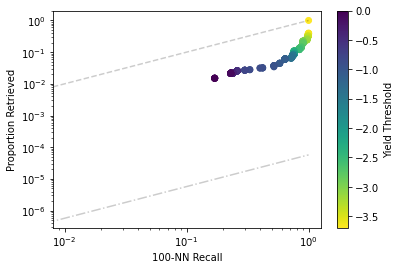

In [32]:
plt.scatter(n,p,c=t, cmap=plt.cm.viridis_r)
plot_baselines(100, len(df))(plt.gca())
plt.xlabel("100-NN Recall")
plt.ylabel("Proportion Retrieved")
plt.colorbar(label="Yield Threshold")

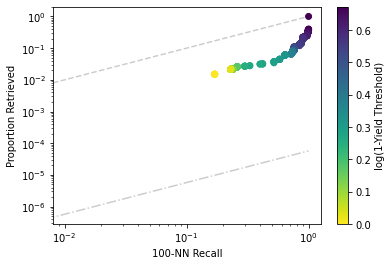

In [33]:
plt.scatter(n,p,c=np.log10(1-t), cmap=plt.cm.viridis_r)
plot_baselines(100, len(df))(plt.gca())
plt.xlabel("100-NN Recall")
plt.ylabel("Proportion Retrieved")
plt.colorbar(label="log(1-Yield Threshold)")

In [10]:
df.sort_values('duplex_yield', ascending=False)

,duplex_yield,euclidean_distance
a2f4f1fb33d2c1d4,1.0000,121.484962
d1078684e0d44e96,1.0000,97.996391
f0227dab95c8c78d,1.0000,108.452278
aa98a889e1c279f0,1.0000,98.077797
049d81cff06e2b77,1.0000,98.400482
...,...,...
4dd47b4104e7a9ed,0.0002,110.474197
4dd46af90da67f23,0.0002,100.494438
4dd4637bf35712a2,0.0002,104.520332
4dd45f71cb32ee94,0.0002,122.523849


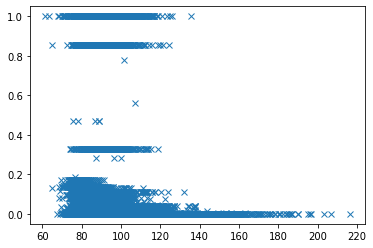

In [34]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 2_000_000
plt.figure()
subset = df.sample(100000)
plt.plot(subset['euclidean_distance'], subset['duplex_yield'], 'x')

In [40]:
from PIL import Image

In [41]:
# The items with top 'k' duplex yields.
k_top = 100
tops = df.sort_values('duplex_yield', ascending=False)[:k_top]

FileNotFoundError: [Errno 2] No such file or directory: '/tf/open_images/extended_targets/images/00/000002b66c9c498e.jpg'

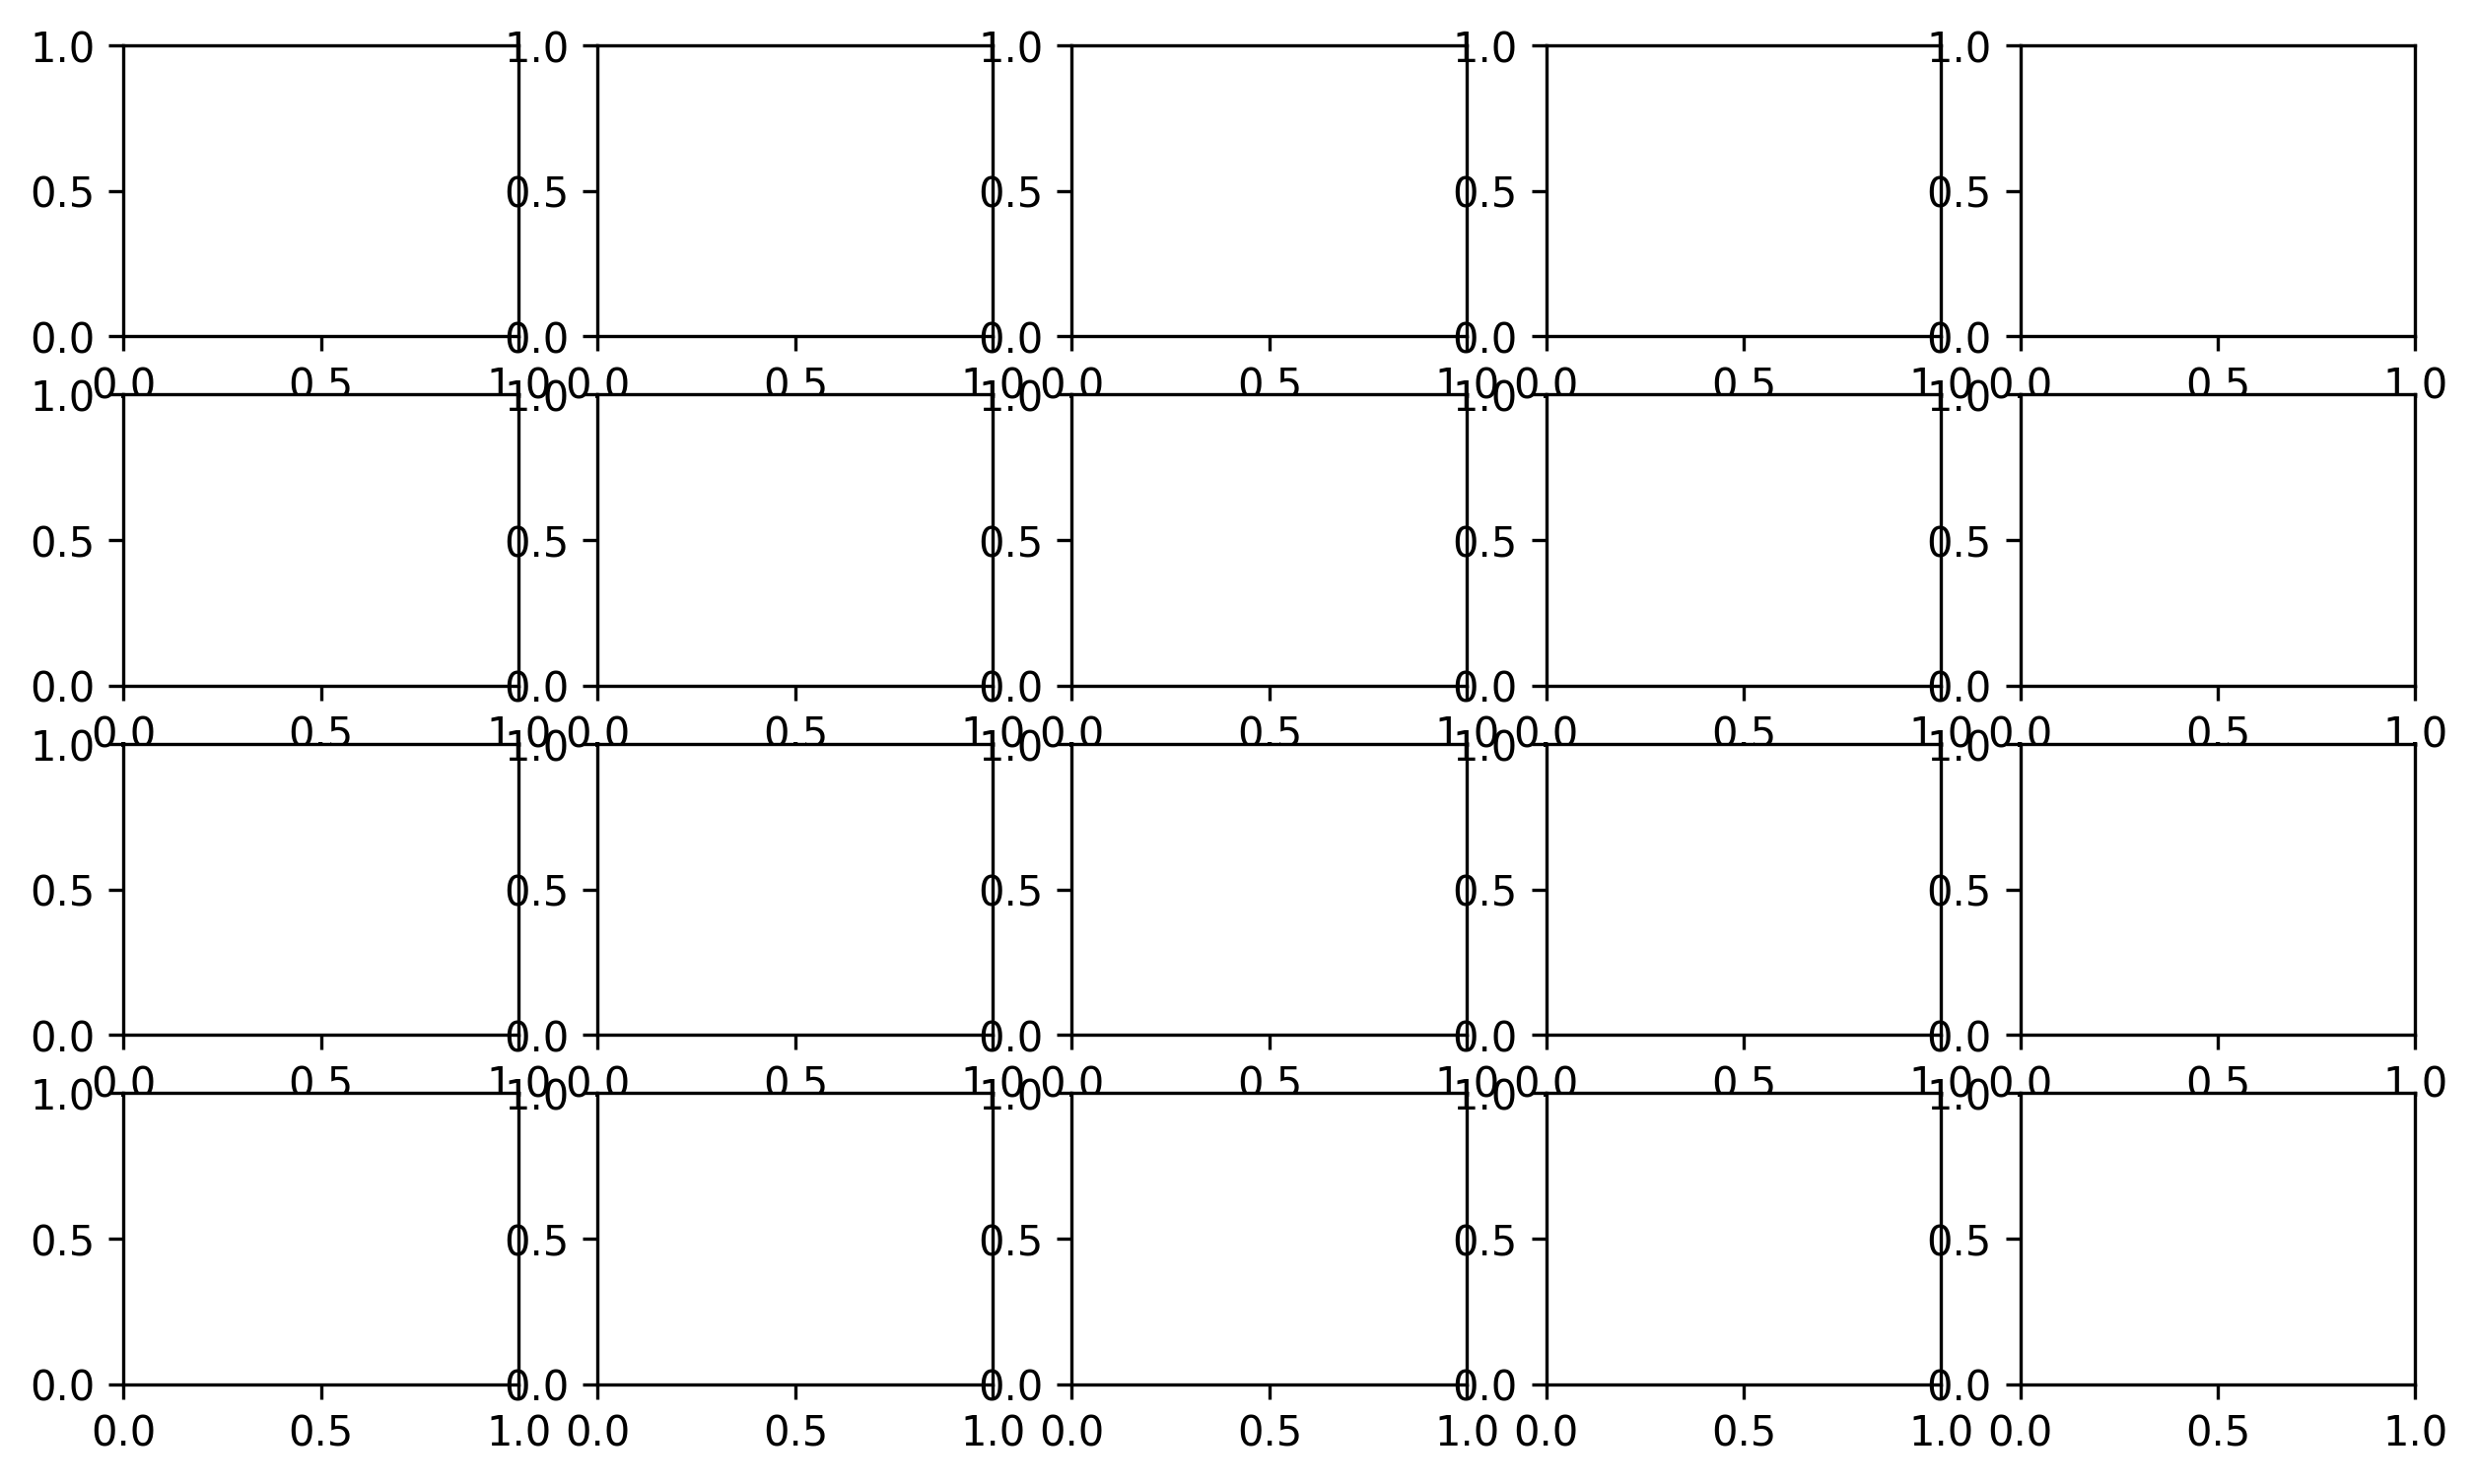

In [43]:
rows = 4
cols = 5
fig, axarr = plt.subplots(rows, cols, figsize = (10,6), dpi=300)
# Plot the top number of highest simulayed yield target-query yields (the number plotted will be rows * cols). 
for ix, ax in enumerate(axarr.flat):
    if ix < len(tops):
        imgid = tops.index[ix]
        img = Image.open('/tf/open_images/extended_targets/images/%s/%s.jpg' % (imgid[:2], imgid))
        new_height = img.width / 1.5
        crop = img.crop([0,img.height/2 - new_height/2,img.width,img.height/2 + new_height/2])
        ax.imshow(crop)
    ax.set_xticks(())
    ax.set_yticks(())
plt.tight_layout()
plt.savefig('/tf/primo/fig.pdf')

In [289]:
600 / 1.5

400.0